## Credit-Risk-part2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/application_train.csv


## Continuting extracting feature to enhance the score

[Link to part#1 with score of 0.754](https://www.kaggle.com/salmaeng/credit-risk-part-1)

In [2]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

I will start by getting the #of client's previous loans using `bureau` and `bureau_balance` data.

* `bureau`: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.

* `bureau_balance`: monthly information about the previous loans. Each month has its own row.

In [3]:
# read in the data into notebook 
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
# groupby client-id, count #previous loans
from pandas import DataFrame

prev_loan_count = bureau.groupby('SK_ID_CURR', as_index = False).count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_count'})

# prev_loan_count = prev_loan_count['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_count'}).head()



In [5]:
prev_loan_count.head()

,SK_ID_CURR,previous_loan_count,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,7,7,7,7,7,7,4,0,7,7,7,6,7,7,7,7
1,100002,8,8,8,8,8,6,6,5,8,8,5,4,8,8,8,7
2,100003,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,0
3,100004,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,0
4,100005,3,3,3,3,3,3,1,1,3,3,3,3,3,3,3,3


In [14]:
# join with the training dataframe
pd.set_option('display.max_column', None)
train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
train = train.merge(prev_loan_count, on = 'SK_ID_CURR', how = 'left')

# fill the missing values with 0

train['previous_loan_count'] = train['previous_loan_count'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_count,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,8.0,8.0,8.0,8.0,6.0,6.0,5.0,8.0,8.0,5.0,4.0,8.0,8.0,8.0,7.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0

In [15]:
train['previous_loan_count'].dtypes

dtype('float64')

It is already there :-)

## Calculating Pearson correlation value.

Investigate the feature importance through the r-value (Pearson correlation), it not a measure of importance for new variables; however, it provide a reference of wheather a varaible will be helpful to the model or not. 

Higher r-value with respect to the dependent variable means any change in that variable would lead to a significant change in the dependent variable. So, in the next step, I would look into the highest absolute value of r-value relative to the dependent variable. 

## KDE
Kernel Density Estimator plot shows the distribution of a single variable relative to the target varaible

In [16]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

I will see the distribution with the `EXT_SOURCE_3` as this is the most important feature in [credit-risk-part-1 kernel](https://www.kaggle.com/salmaeng/credit-risk-part-1)

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


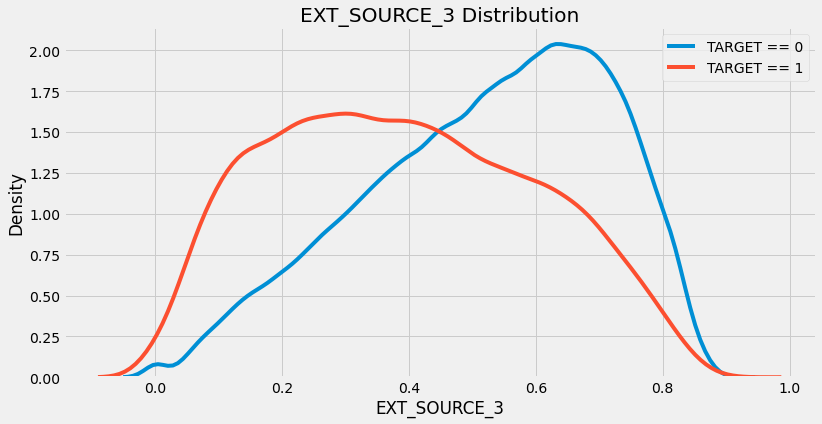

In [17]:
kde_target('EXT_SOURCE_3', train)

It plot the same behaviour as before, so we are good to go and apply it to the `previous_loan_count` variable

The correlation between previous_loan_count and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


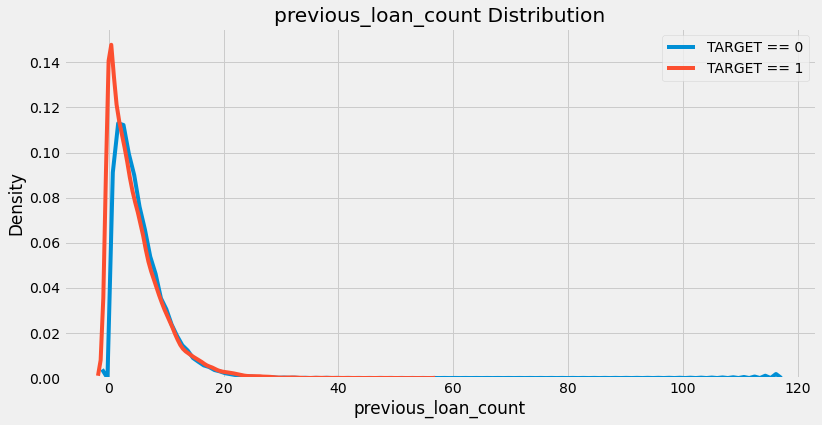

In [18]:
kde_target('previous_loan_count', train)

It's hard to confirm if this variable will be important to the final model. The correlation coefficient is extremely weak and there is almost no significant difference in the distributions.

Let's investigate more variables from the bureau dataframe. I will doing so by getting min, max, avg for numerical variables. 

## Aggregating numeric columns

In [42]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'min','max','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean   min  max   sum              count   
0     100001           7  -735.000000 -1572  -49 -5145                  7   
1     100002           8  -874.000000 -1437 -103 -6992                  8   
2     100003           4 -1400.750000 -2586 -606 -5603                  4   
3     100004           2  -867.000000 -1326 -408 -1734                  2   
4     100005           3  -190.666667  -373  -62  -572                  3   

                   DAYS_CREDIT_ENDDATE                                      \
  mean min max sum               count        mean     min     max     sum   
0  0.0   0   0   0                   7   82.428571 -1329.0  1778.0   577.0   
1  0.0   0   0   0                   6 -349.000000 -1072.0   780.0 -2094.0   
2  0.0   0   0   0                   4 -544.500000 -2434.0  1216.0 -2178.0   
3  0.0   0   0   0                   2 -488.500000  -595.0  -382.0  -977.0   
4  0.0   0   0   0                   3  439.333333  -128.0  1324.0  1318.0   

  DAYS_ENDDATE_FACT                                      \
              count         mean     min    max     sum   
0                 4  -825.500000 -1328.0 -544.0 -3302.0   
1                 6  -697.500000 -1185.0  -36.0 -4185.0   
2                 3 -1097.333333 -2131.0 -540.0 -3292.0   
3                 2  -532.500000  -683.0 -382.0 -1065.0   
4                 1  -123.000000  -123.0 -123.0  -123.0   

  AMT_CREDIT_MAX_OVERDUE                                     \
                   count      mean  min       max       sum   
0                      0       NaN  NaN       NaN     0.000   
1                      5  1681.029  0.0  5043.645  8405.145   
2                      4     0.000  0.0     0.000     0.000   
3                      1     0.000  0.0     0.000     0.000   
4                      1     0.000  0.0     0.000     0.000   

  CNT_CREDIT_PROLONG                  AMT_CREDIT_SUM                          \
               count mean min max sum          count           mean      min   
0                  7  0.0   0   0   0              7  207623.571429  85500.0   
1                  8  0.0   0   0   0              8  108131.945625      0.0   
2                  4  0.0   0   0   0              4  254350.125000  22248.0   
3                  2  0.0   0   0   0              2   94518.900000  94500.0   
4                  3  0.0   0   0   0              3  219042.000000  29826.0   

                         AMT_CREDIT_SUM_DEBT                                \
        max          sum               count           mean  min       max   
0  378000.0  1453365.000                   7   85240.928571  0.0  373239.0   
1  450000.0   865055.565                   5   49156.200000  0.0  245781.0   
2  810000.0  1017400.500                   4       0.000000  0.0       0.0   
3   94537.8   189037.800                   2       0.000000  0.0       0.0   
4  568800.0   657126.000                   3  189469.500000  0.0  543087.0   

            AMT_CREDIT_SUM_LIMIT                                             \
        sum                count          mean  min         max         sum   
0  596686.5                    6       0.00000  0.0       0.000       0.000   
1  245781.0                    4    7997.14125  0.0   31988.565   31988.565   
2       0.0                    4  202500.00000  0.0  810000.000  810000.000   
3       0.0                    2       0.00000  0.0       0.000       0.000   
4  568408.5                    3       0.00000  0.0       0.000       0.000   

  AMT_CREDIT_SUM_OVERDUE                     DAYS_CREDIT_UPDATE              \
                   count mean  min  max  sum              count        mean   
0                      7  0.0  0.0  0.0  0.0                  7  -93.142857   
1                      8  0.0  0.0  0.0  0.0                  8 -499.875000   
2                      4  0.0  0.0  0.0  0.0                  4 -816.000000   
3 

We need to create new names for each of these columns. The following code makes new names by appending the stat to the name. Here we have to deal with the fact that the dataframe has a multi-level index. I find these confusing and hard to work with, so I try to reduce to a single level index as quickly as possible.

In [43]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [44]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-1572,-49,-5145,7,0.0,0,0,0,7,82.428571,-1329.0,1778.0,577.0,4,-825.500000,-1328.0,-544.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,85500.0,378000.0,1453365.000,7,85240.928571,0.0,373239.0,596686.5,6,0.00000,0.0,0.000,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-155,-6,-652,7,3545.357143,0.0,10822.5,24817.5
1,100002,8,-874.000000,-1437,-103,-6992,8,0.0,0,0,0,6,-349.000000,-1072.0,780.0,-2094.0,6,-697.500000,-1185.0,-36.0,-4185.0,5,1681.029,0.0,5043.645,8405.145,8,0.0,0,0,0,8,108131.945625,0.0,450000.0,865055.565,5,49156.200000,0.0,245781.0,245781.0,4,7997.14125,0.0,31988.565,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-1185,-7,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-2586,-606,-5603,4,0.0,0,0,0,4,-544.500000,-2434.0,1216.0,-2178.0,3,-1097.333333,-2131.0,-540.0,-3292.0,4,0.000,0.0,0.000,0.000,4,0.0,0,0,0,4,254350.125000,22248.0,810000.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,0.0,810000.000,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-2131,-43,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-1326,-408,-1734,2,0.0,0,0,0,2,-488.500000,-595.0,-382.0,-977.0,2,-532.500000,-683.0,-382.0,-1065.0,1,0.000,0.0,0.000,0.000,2,0.0,0,0,0,2,94518.900000,94500.0,94537.8,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.0,0.000,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-682,-382,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-373,-62,-572,3,0.0,0,0,0,3,439.333333,-128.0,1324.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.0,0.000,0.000,3,0.0,0,0,0,3,219042.000000,29826.0,568800.0,657126.000,3,189469.500000,0.0,543087.0,568408.5,3,0.00000,0.0,0.000,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-121,-11,-163,3,1420.500000,0.0,4261.5,4261.5


In [45]:
# merge with the train dataset
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_count,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,bureau_CREDIT_ACTIVE_count,bureau_CREDIT_ACTIVE_min,bureau_CREDIT_ACTIVE_max,bureau_CREDIT_ACTIVE_sum,bureau_CREDIT_CURRENCY_count,bureau_CREDIT_CURRENCY_min,bureau_CREDIT_CURRENCY_max,bureau_CREDIT_CURRENCY_sum,bureau_DAYS_CREDIT_count_x,bureau_DAYS_CREDIT_min_x,bureau_DAYS_CREDIT_max_x,bureau_DAYS_CREDIT_sum_x,bureau_CREDIT_DAY_OVERDUE_count_x,bureau_CREDIT_DAY_OVERDUE_min_x,bureau_CREDIT_DAY_OVERDUE_max_x,bureau_CREDIT_DAY_OVERDUE_sum_x,bureau_DAYS_CREDIT_ENDDATE_count_x,bureau_DAYS_CREDIT_ENDDATE_min_x,bureau_DAYS_CREDIT_ENDDATE_max_x,bureau_DAYS_CREDIT_ENDDATE_sum_x,bureau_DAYS_ENDDATE_FACT_count_x,bureau_DAYS_ENDDATE_FACT_min_x,bureau_DAYS_ENDDATE_FACT_max_x,bureau_DAYS_ENDDATE_FACT_sum_x,bureau_AMT_CREDIT_MAX_OVERDUE_count_x,bureau_AMT_CREDIT_MAX_OVERDUE_min_x,bureau_AMT_CREDIT_MAX_OVERDUE_max_x,bureau_AMT_CREDIT_MAX_OVERDUE_sum_x,bureau_CNT_CREDIT_PROLONG_count_x,bureau_CNT_CREDIT_PROLONG_min_x,bureau_CNT_CREDIT_PROLONG_max_x,bureau_CNT_CREDIT_PROLONG_sum_x,bureau_AMT_CREDIT_SUM_count_x,bureau_AMT_CREDIT_SUM_min_x,bureau_AMT_CREDIT_SUM_max_x,bureau_AMT_CREDIT_SUM_sum_x,bureau_AMT_CREDIT_SUM_DEBT_count_x,bureau_AMT_CREDIT_SUM_DEBT_min_x,bureau_AMT_CREDIT_SUM_DEBT_max_x,bureau_AMT_CREDIT_SUM_DEBT_sum_x,bureau_AMT_CREDIT_SUM_LIMIT_count_x,bureau_AMT_CREDIT_SUM_LIMIT_min_x,bureau_AMT_CREDIT_SUM_LIMIT_max_x,bureau_AMT_CREDIT_SUM_LIMIT_sum_x,bureau_AMT_CREDIT_SUM_OVERDUE_count_x,bureau_AMT_CREDIT_SUM_OVERDUE_min_x,bureau_AMT_CREDIT_SUM_OVERDUE_max_x,bureau_AMT_CREDIT_SUM_OVERDUE_sum_x

## Correlations of Aggregated Values with Target

In [47]:
columns[1:5]

['bureau_DAYS_CREDIT_count',
 'bureau_DAYS_CREDIT_mean',
 'bureau_DAYS_CREDIT_min',
 'bureau_DAYS_CREDIT_max']

sort the correlations by the magnitude (absolute value) using the sorted Python function. We also make use of an anonymous lambda function, another important Python operation that is good to know.

In [49]:
# Sort the correlations by the absolute value

pd.set_option('display.max_rows', None)
new_corrs = train.drop(columns=['TARGET']).corrwith(train['TARGET']).sort_values(ascending=False)
new_corrs[:15]

bureau_DAYS_CREDIT_mean             0.089729
DAYS_BIRTH                          0.078239
bureau_DAYS_CREDIT_min_y            0.075248
bureau_DAYS_CREDIT_min_x            0.075248
bureau_DAYS_CREDIT_UPDATE_mean      0.068927
REGION_RATING_CLIENT_W_CITY         0.060893
REGION_RATING_CLIENT                0.058899
bureau_DAYS_ENDDATE_FACT_min_y      0.055887
bureau_DAYS_ENDDATE_FACT_min_x      0.055887
DAYS_LAST_PHONE_CHANGE              0.055218
bureau_DAYS_CREDIT_ENDDATE_sum_y    0.053735
bureau_DAYS_CREDIT_ENDDATE_sum_x    0.053735
bureau_DAYS_ENDDATE_FACT_mean       0.053200
DAYS_ID_PUBLISH                     0.051457
REG_CITY_NOT_WORK_CITY              0.050994
dtype: float64

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


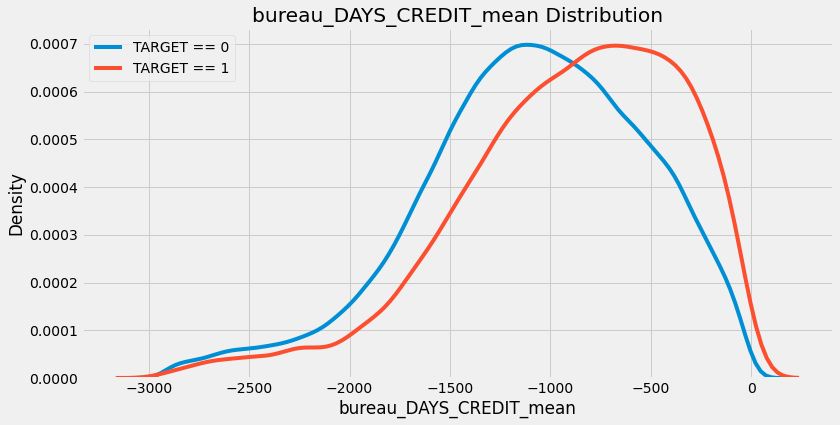

In [50]:
kde_target('bureau_DAYS_CREDIT_mean', train)

The definition of this column is: "How many days before current application did client apply for Credit Bureau credit". My interpretation is this is the number of days that the previous loan was applied for before the application for a loan at Home Credit. Therefore, a larger negative number indicates the loan was further before the current loan application. We see an extremely weak positive relationship between the average of this variable and the target meaning that clients who applied for loans further in the past potentially are more likely to repay loans at Home Credit. With a correlation this weak though, it is just as likely to be noise as a signal.